In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

### Get the Dataset


In [7]:
!wget -c https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-21 15:21:24--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 

416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



### EDA

- Load the data.
- Look at the `median_house_value` variable. Does it have a long tail?

In [8]:
df_all = pd.read_csv("housing.csv")

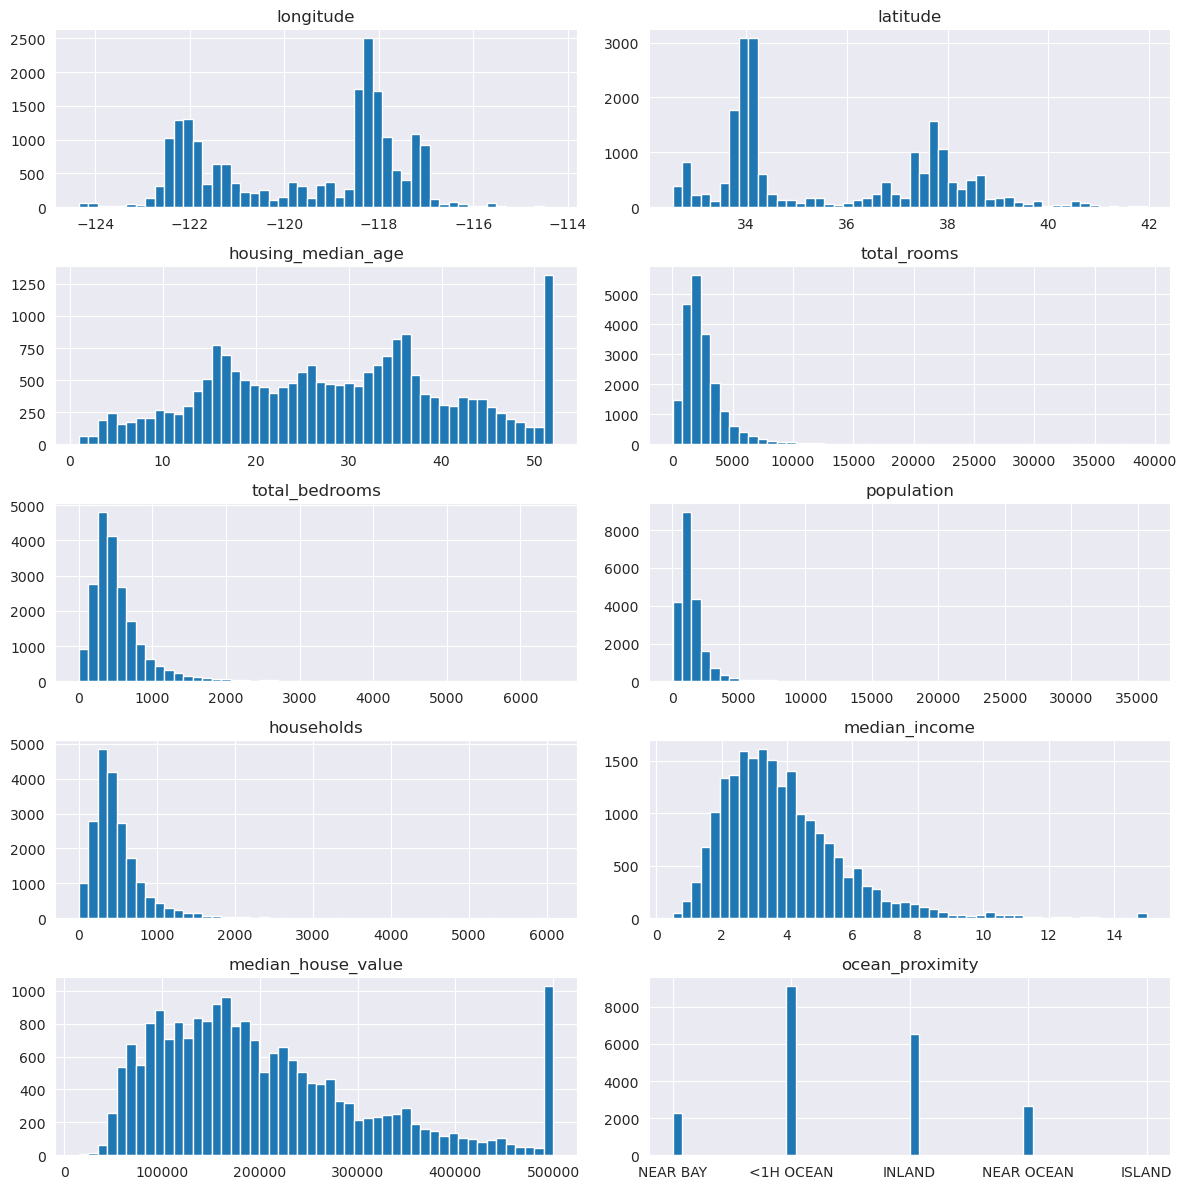

In [9]:
cols = list(df_all.columns)

n_rows = 5
n_cols = 2
fig, ax = plt.subplots(n_rows, n_cols)
fig.set_size_inches(12, 12)

i = 0
for r in range(n_rows):
    for c in range(n_cols):
        ax[r, c].hist(df_all[cols[i]], bins=50)
        ax[r, c].set_title(cols[i])
        i += 1

plt.tight_layout()
plt.show()

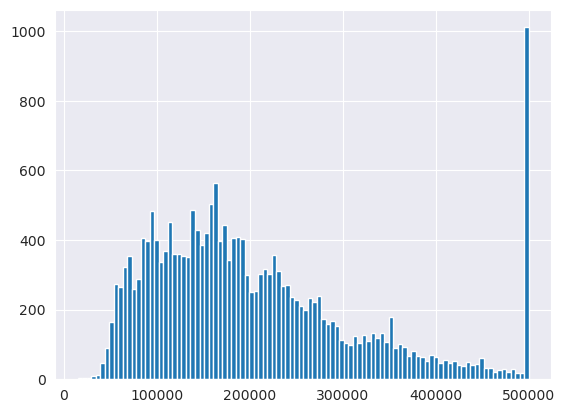

In [10]:
mhv = df_all['median_house_value'].values
plt.hist(mhv, bins=100); plt.show()

- The distribution has a long tail, however there are many values in the last bin

### Preparing the dataset 

For this homework, we only want to use a subset of data. 

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Next, use only the following columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

In [11]:
filter1 = df_all["ocean_proximity"] == "<1H OCEAN"
filter2 = df_all["ocean_proximity"] == "INLAND"

cols =  ["latitude", "longitude", "housing_median_age", 
         "total_rooms", "total_bedrooms", "population", 
         "households", "median_income", 
         "median_house_value"]
# alternatively dropping "ocean_proximity" possible

df = df_all[filter1 | filter2]
print(df.shape)
df = df[cols]

print(df.shape)
df.head()

(15687, 10)
(15687, 9)


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


# Question 1

**There's one feature with missing values. What is it?**

In [33]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Answer: `total_bedrooms`

# Question 2

**What's the median (50% percentile) for variable `'population'`?**

In [32]:
df["population"].describe().round(2)

count    15687.00
mean      1466.32
std       1180.39
min          3.00
25%        802.00
50%       1195.00
75%       1777.00
max      35682.00
Name: population, dtype: float64

### Answer: $1195$

# Prepare and split the dataset

- Shuffle the initial dataset, use seed `42`.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.

In [14]:
np.random.seed(42)

def split_data(df, split=[0.6, 0.2, 0.2]):
    df = df.copy()
    assert sum(split) == 1.0
    # Shuffle data indices
    n = len(df)
    idx = np.arange(n)
    np.random.shuffle(idx)

    # Splitting the data
    n_val = int(n * split[1]) # 20% of the dataset-size
    n_test = int(n * split[2])
    n_train = n - n_val - n_test # int(n * 0.6)

    df_val = df.iloc[idx[:n_val]] 
    df_test = df.iloc[idx[n_val:(n_val + n_test)]]
    df_train = df.iloc[idx[(n_val + n_test):]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Applying log-transformation on the target-value
    y_train = np.log1p(df_train["median_house_value"].values)
    y_val   = np.log1p(df_val["median_house_value"].values)
    y_test  = np.log1p(df_test["median_house_value"].values)

    del df_train["median_house_value"]
    del df_val["median_house_value"]
    del df_test["median_house_value"]

    return df_train, y_train, df_val, y_val, df_test, y_test


In [15]:
df_train, y_train, df_val, y_val, df_test, y_test = \
    split_data(df, split=[0.6, 0.2, 0.2])

# Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using `round(score, 2)`
- Which option gives better RMSE?

In [16]:
# columns to use here: just using the columns from the extracted dataframes
features = df_train.columns
print(list(features))

['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [17]:
# Functions for this question

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y
    
    return w[0], w[1:]
     

def prepare_X(df, na_val):
    df_num = df[features]
    df_num = df_num.fillna(na_val)
    X = df_num.values
    return X

def rmse(y_pred, y):
    return np.sqrt(np.mean((y_pred - y)**2))

`fillna(0)`-Version

In [18]:
na_val = 0
print("na_val = ", na_val)


X_train_0 = prepare_X(df_train, na_val)
X_val_0 = prepare_X(df_val, na_val)

w0_0, w_0 = train_linear_regression(X_train_0, y_train)
y_pred_0 = w0_0 + X_val_0 @ w_0

rmse_0 = np.round(rmse(y_pred_0, y_val), 2)
print("rmse(0): ", rmse_0)

na_val =  0
rmse(0):  0.34


`fillna(mean)`-Version

In [19]:
na_val = df_train["total_bedrooms"].mean()
print("na_val = ", na_val)

X_train_mean = prepare_X(df_train, na_val)
X_val_mean = prepare_X(df_val, na_val)

w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w0_mean + X_val_mean @ w_mean

rmse_mean = np.round(rmse(y_pred_mean, y_val), 2)
print("rmse(mean): ", rmse_mean)


na_val =  538.3024254131788
rmse(mean):  0.34


### Answer: Both are equally good

# Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which `r` gives the best RMSE?


In [20]:
na_val = 0
R = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

def train_linear_regression_reg(X, y, r=0.01):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)

    w_full = XTX_inv @ X.T @ y
    return w_full[0], w_full[1:]

In [21]:
results = []

for r in R:
    # Train the model
    X_train = prepare_X(df_train, na_val)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    # Evaluate the model
    X_val = prepare_X(df_val, na_val)
    y_pred = w0 + X_val @ w

    rmse_r = np.round(rmse(y_pred, y_val), 2)

    # results.append((r, [w0] + w, rmse_r))
    results.append((r, rmse_r))
    print(r, round(w0, 6), rmse_r)


min_idx = np.argmin(np.array(results))
best_r = R[min_idx]
print("Best r = ", best_r)

0 -10.38121 0.34
1e-06 -10.381188 0.34
0.0001 -10.379034 0.34
0.001 -10.359493 0.34
0.01 -10.168054 0.34
0.1 -8.582033 0.34
1 -3.351372 0.34
5 -0.901639 0.34
10 -0.469907 0.34
Best r =  0


### Answer: $r = 0$

# Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
- For each seed, do the train/validation/test split with $60\%/20\%/20\%$ distribution.
- Fill the missing values with `0` and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
- What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
- Round the result to 3 decimal digits (`round(std, 3)`)

In [22]:
na_val = 0

scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, y_train, df_val, y_val, df_test, y_test = \
        split_data(df, split=[0.6, 0.2, 0.2])
    
    # Data preprocessing
    X_train = prepare_X(df_train, na_val)
    X_val = prepare_X(df_val, na_val)

    # Train the model
    w0, w = train_linear_regression_reg(X_train, y_train, r=0)

    # Prediction 
    y_pred = w0 + X_val @ w

    # Evaluation
    score = rmse(y_pred, y_val)
    scores.append(score)
    print(f"Seed: {seed} | rmse: {np.round(score , 2)}")

    
rmse_std = np.std(scores)
print("std(rmse): ", np.round(rmse_std, 3))

Seed: 0 | rmse: 0.34
Seed: 1 | rmse: 0.34
Seed: 2 | rmse: 0.34
Seed: 3 | rmse: 0.34
Seed: 4 | rmse: 0.34
Seed: 5 | rmse: 0.34
Seed: 6 | rmse: 0.34
Seed: 7 | rmse: 0.33
Seed: 8 | rmse: 0.34
Seed: 9 | rmse: 0.34
std(rmse):  0.003


### Answer: $\sigma = 0.005$
The standard deviation is relatively low. This means that the model predicts similar results with different seeds and the model is seen as stable.

# Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with `r=0.001`. 
- What's the RMSE on the test dataset?

In [31]:
# Setting specific seed
np.random.seed(9)

# Get the data
df_train, y_train, df_val, y_val, df_test, y_test = \
    split_data(df, split=[0.6, 0.2, 0.2])

df_train_full = pd.concat([df_train, df_val])
y_train_full = np.concatenate([y_train, y_val])

na_val = 0
X_train_full = prepare_X(df_train_full, na_val)
X_test = prepare_X(df_test, na_val)

# Training the model
r = 0.001
w0, w = train_linear_regression_reg(X_train_full, y_train_full, r)


# Evaluation
y_pred = w0 + X_test @ w
score_test = rmse(y_pred, y_test)
print(f"rmse = {np.round(score_test, 2)}")


rmse = 0.34


### Answer: $0.33$